[None, None, None, None, None, None, None, None, None, None, None, None]

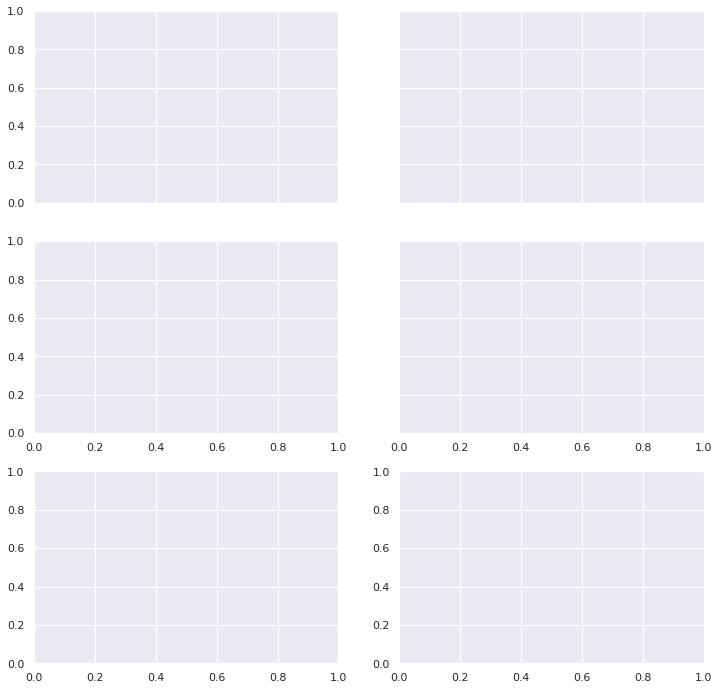

In [2]:
# Imports
import os

import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import setp
from matplotlib.ticker import PercentFormatter

from switch_model.tools.graph.main import GraphTools, Scenario

# Define folders
rel_path_base = "../../../../switch_runs/ldes_runs"
output_file_name="Figure 2"
root_path = os.path.normpath(os.path.join(os.getcwd(), rel_path_base))
graph_dir=os.path.join(root_path,"LDES_paper_graphs")
output_path=os.path.join(graph_dir, output_file_name)
get_rel_path = lambda ext: os.path.join(rel_path_base, ext)

# Define scenarios
baseline = Scenario(get_rel_path("1342"), name=1.94)
min_2 = Scenario(get_rel_path("M7"), name=2)
min_4 = Scenario(get_rel_path("M6"), name=4)
min_8 = Scenario(get_rel_path("M5"), name=8)
min_16 = Scenario(get_rel_path("M4"), name=16)
min_32 = Scenario(get_rel_path("M3"), name=32)
min_64 = Scenario(get_rel_path("M2"), name=64)
scenarios = [baseline, min_2, min_4, min_8, min_16, min_32, min_64]

# Define constants
STORAGE_CAPACITY_LEGEND = "Storage Capacity (TWh)"
X_LABEL = "WECC-wide Storage Capacity (TWh)"

# Prepare graph tools
tools = GraphTools(scenarios=scenarios, graph_dir=graph_dir)
tools.pre_graphing(multi_scenario=True, name=output_file_name)

# Specify formatting and get figure
tools.plt.rcParams['font.family'] = 'sans-serif'
figure_size = (12, 12)
fig = tools.get_figure(size=figure_size)

# Define save() function to use in charts
def save():
    #fig.show()
    fig.savefig(output_path, bbox_inches="tight")
    print("Saved figure to " + output_path)
    return fig

ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2, sharey=ax1)
ax3 = fig.add_subplot(3, 2, 3, sharey=ax1, sharex=ax1)
ax4 = fig.add_subplot(3, 2, 4, sharey=ax1, sharex=ax2)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6)

setp(ax2.get_yticklabels(), visible=False)
setp(ax4.get_yticklabels(), visible=False)
setp(ax1.get_xticklabels(), visible=False)
setp(ax2.get_xticklabels(), visible=False)

In [3]:
def filter_scenario(df, scenario_name):
    return df[df["scenario_name"] == scenario_name].drop(columns=["scenario_name"]).copy()

def figure_2_energy_balance(tools, ax, scenario_name):
    # return
    # Get dispatch dataframe
    dispatch = tools.get_dataframe("dispatch.csv", usecols=[
        "timestamp", "gen_tech", "gen_energy_source", "DispatchGen_MW", "scenario_name"
    ]).rename({"DispatchGen_MW": "value"}, axis=1)
    dispatch = filter_scenario(dispatch, scenario_name)
    dispatch = tools.transform.gen_type(dispatch)

    # Sum dispatch across all the projects of the same type and timepoint
    dispatch = dispatch.groupby(["timestamp", "gen_type"], as_index=False).sum()
    dispatch = dispatch[dispatch["gen_type"] != "Storage"]

    # Get load dataframe
    load = tools.get_dataframe("load_balance.csv", usecols=[
        "timestamp", "zone_demand_mw", "TXPowerNet", "scenario_name"
    ])
    load = filter_scenario(load, scenario_name)

    def process_time(df):
        df = df.astype({"period": int})
        df = df[df["period"] == df["period"].max()].drop(columns="period")
        return df.set_index("datetime")

    # Sum load across all the load zones
    load = load.groupby("timestamp", as_index=False).sum()

    # Include Tx Losses in demand and flip sign
    load["value"] = (load["zone_demand_mw"] + load["TXPowerNet"]) * -1

    # Rename and convert from wide to long format
    load = load[["timestamp", "value"]]

    # Add the timestamp information and make period string to ensure it doesn't mess up the graphing
    dispatch = process_time(tools.transform.timestamp(dispatch))
    load = process_time(tools.transform.timestamp(load))

    # Convert to TWh (incl. multiply by timepoint duration)
    dispatch["value"] *= dispatch["tp_duration"] / 1e6
    load["value"] *= load["tp_duration"] / 1e6

    days = 14
    freq = str(days) + "D"
    offset = tools.pd.Timedelta(freq) / 2

    def rolling_sum(df):
        df = df.rolling(freq, center=True).value.sum().reset_index()
        df["value"] /= days
        df = df[(df.datetime.min() + offset < df.datetime) & (df.datetime < df.datetime.max() - offset)]
        return df

    dispatch = rolling_sum(dispatch.groupby("gen_type", as_index=False))
    load = rolling_sum(load).set_index("datetime")["value"]

    # Get the state of charge data
    soc = tools.get_dataframe("StateOfCharge.csv", dtype={"STORAGE_GEN_TPS_1": str}).rename(columns={"STORAGE_GEN_TPS_2": "timepoint", "StateOfCharge": "value"})
    soc = filter_scenario(soc, scenario_name)
    # Sum over all the projects that are in the same scenario with the same timepoint
    soc = soc.groupby(["timepoint"], as_index=False).sum()
    soc["value"] /= 1e6  # Convert to TWh
    max_soc = soc["value"].max()

    # Group by time
    soc = process_time(tools.transform.timestamp(soc, use_timepoint=True, key_col="timepoint"))
    soc = soc.rolling(freq, center=True)["value"].mean().reset_index()
    soc = soc[(soc.datetime.min() + offset < soc.datetime) & (soc.datetime < soc.datetime.max() - offset)]
    soc = soc.set_index("datetime")["value"]

    dispatch = dispatch[dispatch["value"] != 0]
    dispatch = dispatch.pivot(columns="gen_type", index="datetime", values="value")
    dispatch = dispatch[dispatch.std().sort_values().index].rename_axis("Technology", axis=1)
    total_dispatch = dispatch.sum(axis=1)

    max_val = max(total_dispatch.max(), load.max())

    # Scale soc to the graph
    soc *= 100 / scenario_name

    # Plot
    # Get the colors for the lines
    # plot
    ax.set_ylim(0, max_val * 1.05)
    dispatch.plot(
        ax=ax,
        color=tools.get_colors(),
        legend=False,
        xlabel=""
    )
    ax2 = ax.twinx()
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.set_ylim(0, 100)
    soc.plot(ax=ax2, color="black", linestyle="dotted", label="State of Charge", xlabel="")
    load.plot(ax=ax, color="red", linestyle="dashed", label="Total Demand", xlabel="")
    total_dispatch.plot(ax=ax, color="green", linestyle="dashed", label="Total Generation", xlabel="")
    ax.fill_between(total_dispatch.index, total_dispatch.values, load.values, alpha=0.2, where=load < total_dispatch,
                    facecolor="green")
    ax.fill_between(total_dispatch.index, total_dispatch.values, load.values, alpha=0.2, where=load > total_dispatch,
                    facecolor="red")
    ax.set_title(str(scenario_name) + "TWh of storage")
    return save()

figure_2_energy_balance(tools, ax1, scenario_name=1.94)

Saved figure to /data/home/machstg/switch_runs/ldes_runs/LDES_paper_graphs/Figure 2


In [ ]:
figure_2_energy_balance(tools, ax2, scenario_name=4)

In [ ]:
figure_2_energy_balance(tools, ax3, scenario_name=16)

In [ ]:
figure_2_energy_balance(tools, ax4, scenario_name=64)

In [ ]:
ax=ax5
ax.clear()
df = tools.get_dataframe("gen_cap.csv",
                         usecols=["gen_tech", "gen_energy_source", "GenCapacity", "scenario_name"])
df = tools.transform.gen_type(df)
df = df.rename({"GenCapacity": "value"}, axis=1)
df = df.groupby(["scenario_name", "gen_type"], as_index=False).value.sum()
scaling = df[df["scenario_name"] == 1.94][["gen_type", "value"]].rename(columns={"value": "scaling"})
df = df.merge(scaling, on="gen_type")
df.value /= df.scaling
df.value = (df.value - 1) * 100
df = df[df["gen_type"].isin(("Wind", "Solar", "Biomass"))]
df = df.pivot(index="scenario_name", columns="gen_type", values="value")
df = df.rename_axis("Technology", axis=1)
df.plot(
    ax=ax,
    color=tools.get_colors(),
    legend=False
)
ax.set_ylabel("Percent Change in Installed Capacity against Baseline")
ax.yaxis.set_major_formatter(PercentFormatter())
ax.set_xlabel(X_LABEL)
ax.set_title("B. Impact of Storage on Generation Mix")
save()

In [ ]:
ax=ax6
ax.clear()

df = tools.get_dataframe("storage_builds.csv").astype({"scenario_name": "int"})
df = df[df["build_year"] == 2050]
df["power"] = df["IncrementalPowerCapacityMW"] / 1000
df["energy"] = df["IncrementalEnergyCapacityMWh"] / 1000

df = tools.transform.load_zone(df)
df = df.groupby(["scenario_name", "region"], as_index=False)[["power", "energy"]].sum()
# df = df[df["scenario_name"] < 30]
# Filter out rows where there's no power built
# df = df[df["power"] > 0.0001]
df["duration"] = (df["energy"] / df["power"]) / 24
df = df.rename(columns={"scenario_name": STORAGE_CAPACITY_LEGEND})
average_duration = df.groupby(STORAGE_CAPACITY_LEGEND).sum()
average_duration = ((average_duration["energy"] / average_duration["power"]) / 24).rename("duration")
average_power = df.groupby(STORAGE_CAPACITY_LEGEND)["power"].mean().rename("power")
average = pd.concat([average_power, average_duration], axis=1).reset_index()
ax.scatter(
    df["duration"],
    df["power"],
    c=df[STORAGE_CAPACITY_LEGEND],
    s=10,
    cmap="seismic"
)

average.drop(STORAGE_CAPACITY_LEGEND, axis=1).set_index("duration").plot(ax=ax, legend=False)

average.plot.scatter(
    "duration",
    "power",
    c=STORAGE_CAPACITY_LEGEND,
    s=50,
    colormap="seismic",
    ax=ax,
    marker="^",
    logx=True,
    logy=True,
)
# df_lines = df.pivot(index="duration", values="power", columns="region").interpolate(axis='index', limit_area="inside")
# df_lines.plot(ax=ax, legend=False, color="black", linewidth=0.5)
ax.tick_params(axis='x', which='both')
ax.set_xlabel("Storage Duration (days)")
ax.set_ylabel("Storage Power (GW)")
ax.set_title("C. Storage Buildout Per Scenario")
save()

In [ ]:
handles, labels = ax1.get_legend_handles_labels()
unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
plt.figlegend(*zip(*unique))
save()